In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [30]:
import os
import sys
os.getcwd()

'C:\\Users\\Sophia\\Documents\\EPFL\\4rd_semester\\data_visualization\\project\\project-2023-unsdg_viz\\milestone1'

In [201]:
# get the absolute path of the current working directory
cwd = os.path.abspath(os.getcwd())

# go up one level in the directory tree
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))

# go into the 'data' directory
data_dir = os.path.join(parent_dir, 'data')

In [221]:
datafolder = data_dir + '\\' #'./data/' 
data = pd.read_csv(datafolder + 'unsdg_2002_2021.csv')
co2 = pd.read_csv(datafolder + 'annual-co-emissions-by-region.csv')
gdp = pd.read_csv(datafolder + 'gross-domestic-product.csv')
literacy = pd.read_csv(datafolder + 'literacy-rate-adults.csv')
no_edu = pd.read_csv(datafolder + 'rate-of-no-education.csv')
air_pollution = pd.read_csv(datafolder + 'share-above-who-pollution-guidelines.csv')
renewable_energy = pd.read_csv(datafolder + 'co2-per-capita-vs-renewable-electricity.csv')

In [222]:
co2_list = list(co2.Entity.unique()) 
gdp_list = list(gdp.Entity.unique()) 
no_edu_list = list(no_edu.Entity.unique()) 
air_pollution_list = list(air_pollution.Entity.unique()) 
renewable_energy_list = list(renewable_energy.Entity.unique()) 
data_list = list(data.country.unique())

In [223]:
replace_dict = {'Bolivia (Plurinational State of)': 'Bolivia', 
                'Bonaire, Sint Eustatius and Saba': 'Bonaire Sint Eustatius and Saba',
               'China, Hong Kong Special Administrative Region': 'Hong Kong',
                "Côte d'Ivoire": "Cote d'Ivoire",
                "Democratic People's Republic of Korea": 'South Korea',
                'Republic of Korea':'South Korea',
                'Democratic Republic of the Congo': 'Democratic Republic of Congo',
                'Falkland Islands (Malvinas)': 'Falkland Islands',
                'French Southern Territories': 'French Equatorial Africa (GCP)',
                'Iran (Islamic Republic of)': 'Iran',
                "Lao People's Democratic Republic": 'Laos',
                'Micronesia (Federated States of)': 'Micronesia (country)',
                'Republic of Moldova': 'Moldova',
                'Russian Federation':  'Russia', 
                'Saint Martin (French Part)': 'Saint Martin (French part)',
                'Serbia and Montenegro [former]' : 'Montenegro',
                'State of Palestine': 'Palestine',
                'Sudan [former]': 'Sudan',
                'Svalbard and Jan Mayen Islands': 'Svalbard and Jan Mayen',
                'Syrian Arab Republic': 'Syria',
                'Timor-Leste': 'Timor',
                'Türkiye': 'Turkey',
                'United Kingdom (England and Wales)': 'United Kingdom',
                'United Kingdom (Northern Ireland)': 'Ireland',
                'United Republic of Tanzania': 'Tanzania',
                'United States of America': 'United States',
                'Venezuela (Bolivarian Republic of)': 'Venezuela',
                'Viet Nam': 'Vietnam',
                'Wallis and Futuna Islands': 'Wallis and Futuna',
                'Yugoslavia [former]': 'Bosnia and Herzegovina'
               }
data.country = data.country.replace(replace_dict)

In [224]:
data_outer = data.merge(co2[['Entity', 'Annual CO₂ emissions (zero filled)', 'Year']], 
                              left_on = ['country', 'dt_year'], right_on = ['Entity', 'Year'], how = 'right')

In [225]:
data_outer = data_outer.merge(no_edu[['Entity', 'IIASA rates of no education projections (IIASA (2015))', 'Year']], 
                        left_on = ['Entity', 'Year'], right_on = ['Entity', 'Year'], how = 'left')

In [226]:
data_outer = data_outer.merge(gdp[['Entity', 'GDP (constant 2015 US$)', 'Year']], 
                              left_on = ['Entity', 'Year'], right_on = ['Entity', 'Year'], how = 'left')

In [227]:
data_outer = data_outer.merge(literacy[['Entity', 'Literacy rate, adult total (% of people ages 15 and above)', 'Year']], 
                              left_on = ['Entity', 'Year'], right_on = ['Entity', 'Year'], how = 'left')

In [228]:
data_outer = data_outer.merge(air_pollution[['Entity', 'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)', 'Year']], 
                              left_on = ['Entity', 'Year'], right_on = ['Entity', 'Year'], how = 'left')

In [229]:
data_outer = data_outer.merge(renewable_energy[['Entity', 'Renewables (% electricity)', 'Year']], 
                              left_on = ['Entity', 'Year'], right_on = ['Entity', 'Year'], how = 'left')

In [230]:
data_outer = data_outer.drop(columns = ['country', 'dt_year'])
data_outer.rename(columns={'Entity': 'country'}, inplace=True)

In [231]:
# Interpolate between measurement
data_viz = data_outer.groupby('country').apply(pd.DataFrame.interpolate)

In [232]:
# Extract interesting feature based on Milestone 1
data_viz = data_viz[['Year', 'country','co2emissions_from_fuel_combustion_in_millions_of_tonnes', 
      'total_government_revenue_proportion_of_gdp_perc',  'fdi_inflows_millionusd',
      'annual_growth_rate_perc',
      'Annual CO₂ emissions (zero filled)',
     'GDP (constant 2015 US$)', 'mortality_rate_perc',
         'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
         'Literacy rate, adult total (% of people ages 15 and above)', 'Renewables (% electricity)']]

In [233]:
# Rename feature
rename_dict = {'co2emissions_from_fuel_combustion_in_millions_of_tonnes': 'CO2_fuel_combustion', 
      'total_government_revenue_proportion_of_gdp_perc':'Revenue',  'fdi_inflows_millionusd':'FDI',
      'annual_growth_rate_perc':'Growth_rate',
      'Annual CO₂ emissions (zero filled)':'CO2_emission',
     'GDP (constant 2015 US$)':'GDP', 'mortality_rate_perc':'Mortality_rate',
         'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)':'Air pollution',
         'Literacy rate, adult total (% of people ages 15 and above)':'Literacy rate', 
              'Renewables (% electricity)': 'Renewable_energy'}
data_viz = data_viz.rename(columns=rename_dict)

In [234]:
data_viz.to_pickle("./data_viz.pkl")

***
For correlation viz

In [236]:
# Only keep countries that have info about CO2
data_viz = data_viz[data_viz.country.isin(co2.Entity)]

In [240]:
# Calculate number of NaN
def NaN_percentage(df):
    '''
    Returns a df with columnname and their respective number of NaN and what percentage this corresponds to.
    Args:
        df = movies, characters
    '''
    
    n_NaN = []
    perc_NaN = []
    length = len(df)

    for column in df:
        i_nan = df[column].isna().sum()
        perc_nan = i_nan/ length
        n_NaN.append(i_nan)
        perc_NaN.append(perc_nan)

    # Create df with results
    index_df = df.columns.to_list()
    df_NaN = pd.DataFrame({'number of NaN':n_NaN, 'percentage of NaN':perc_NaN}, index= index_df )
    return df_NaN

***
#### Correlation matrix - heatmap
Availability of data varies with time -> divide data into 2002 - 2005, 2005-2010, 2010-2015, 2015-2021. <br>
Keep features that have a NaN perc <= 30% <br>
remove all records that contain NaN

In [241]:
import plotly as plotly
import plotly.io as pio
import plotly.graph_objects as go

In [272]:
corr_viz1 = data_viz2[(data_viz2.Year<2005)]
corr_viz2 = data_viz[(data_viz.Year>=2005)&(data_viz.Year<2010)]
corr_viz3 = data_viz[(data_viz.Year>=2010)&(data_viz.Year<2015)]
corr_viz4 = data_viz[(data_viz.Year>=2015)]

In [273]:
NaN_percentage(corr_viz1)

,number of NaN,percentage of NaN
Year,0,0.000000
country,0,0.000000
CO2_fuel_combustion,934,0.686765
Revenue,984,0.723529
FDI,754,0.554412
Growth_rate,740,0.544118
CO2_emission,0,0.000000
GDP,366,0.269118
Mortality_rate,1360,1.000000
Air pollution,375,0.275735


In [271]:
data_viz2 = data_viz[data_viz.Year>= 2000]

In [267]:
gdp.Year.min()

1960

In [244]:
import plotly.offline as offline

In [249]:
period = 1
if period ==1:
        df_viz = corr_viz1
elif period == 2:
        df_viz = corr_viz2
elif period == 3:
        df_viz = corr_viz3  
elif period == 4:
        df_viz = corr_viz4
else:
        print('Error, no valid Period')

In [251]:
df_viz

,Year,country,CO2_fuel_combustion,Revenue,FDI,Growth_rate,CO2_emission,GDP,Mortality_rate,Air pollution,Literacy rate,Renewable_energy
0,1750,Afghanistan,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,1751,Afghanistan,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1752,Afghanistan,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,1753,Afghanistan,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,1754,Afghanistan,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
73246,2000,Zimbabwe,NaN,NaN,NaN,NaN,13818202.0,2.015994e+10,NaN,100.0,83.542109,51.038578
73247,2001,Zimbabwe,NaN,NaN,NaN,NaN,12508722.0,2.045017e+10,NaN,100.0,83.545800,42.875988
73248,2002,Zimbabwe,12.25,NaN,3.8,-0.061782,11895839.0,1.863133e+10,NaN,100.0,83.549491,50.121063
73249,2003,Zimbabwe,10.02,NaN,25.9,-0.076776,10609583.0,1.546492e+10,NaN,100.0,83.553182,65.105385


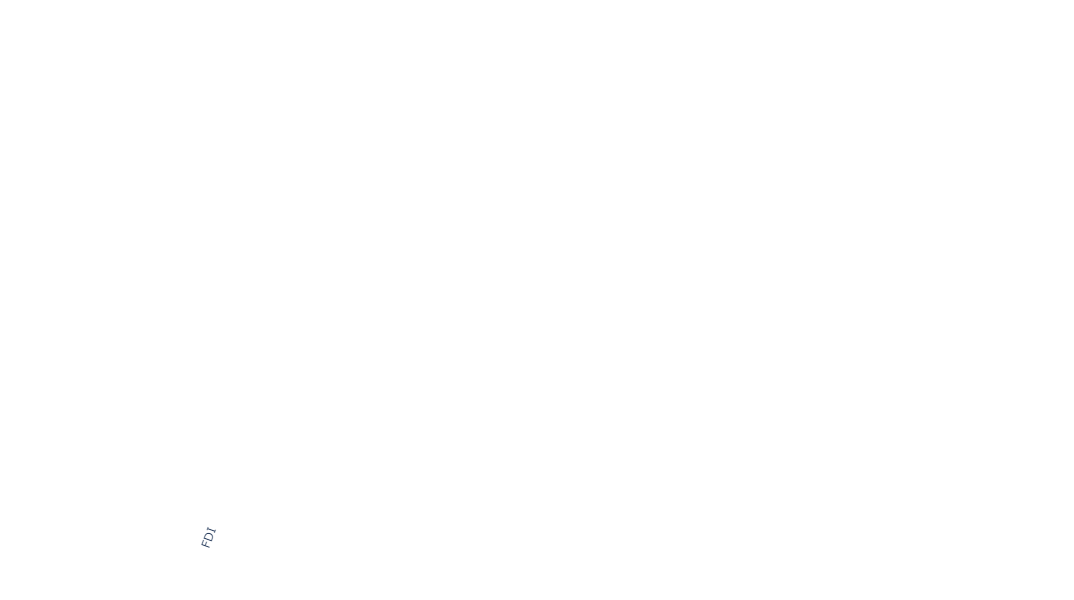

In [250]:
def corr_heatmap(corr, period):
    custom_colorscale = [
    [0, '#3A27AE'],
    [0.49, '#8DE9F0'], 
    [0.51, '#F4F267'],
    [1, '#F27762']]
    
    nan_perc = NaN_percentage(corr)
    keep_index = nan_perc[nan_perc.iloc[:,1]<=0.3].index[2:]
    corr = corr.loc[:,keep_index].dropna()
    corr_matrix  = corr.corr() # Compute pairwise correlation of columns, excluding NA/null values.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matr_viz = corr_matrix.mask(mask)
    pio.templates.default = "plotly_white"

    heat = go.Heatmap(
        z = corr_matr_viz,
        x = corr_matr_viz.columns.values,
        y = corr_matr_viz.columns.values,
        zmin = - 1, # Sets the lower bound of the color domain
        zmax = 1,
        xgap = 1, # Sets the horizontal gap (in pixels) between bricks
        ygap = 1,
        colorscale = custom_colorscale #'thermal'
    )
    if period ==1:
        x_dict = dict(
                ticktext= ['FDI', 'Growth rate', 'CO2 emission', 'GDP', ''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'Growth rate', 'CO2 emission', 'GDP',
           'Renewable energy share'],
                tickvals=list(range(len(corr_matr_viz.columns))))
    elif period == 2:
        x_dict = dict(
                ticktext= ['FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))
    elif period == 3:
        x_dict = dict(
                ticktext= ['Revenue','FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'FDI', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))      
    elif period == 4:
        x_dict = dict(
                ticktext= ['Revenue','FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'FDI', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))         
    else:
        print('Error, no valid Period')

    layout = go.Layout(
        width=600, 
        height=600,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        yaxis_autorange='reversed',
        xaxis_tickangle= -70,
        xaxis= x_dict, 
        yaxis = y_dict)

    fig=go.Figure(data=[heat], layout=layout)
    config = {'displayModeBar': False}

    # display the figure with the config object
    fig.show(config=config)
    
    #fig.write_html(datafolder+"heatmap2.html", config=config)
    #plotly.offline.plot(fig, filename='file.html')
    offline.plot(fig,  include_plotlyjs=False, output_type='div')
    return corr_matr_viz, x_dict, y_dict
    
corr_matr_viz, x_dict, y_dict = corr_heatmap(df_viz, period) # To change depending on plot

In [248]:
corr_matr_viz.columns = x_dict['ticktext']
corr_matr_viz.index = y_dict['ticktext']

ValueError: Length mismatch: Expected axis has 6 elements, new values have 8 elements

In [46]:
corr_matr_viz

,Revenue,FDI,Growth rate,CO2 emission,GDP,Mortality rate,Air pollution,
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FDI,0.053130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Growth rate,0.002213,0.077261,NaN,NaN,NaN,NaN,NaN,NaN
CO2 emission,-0.016778,0.578636,0.084888,NaN,NaN,NaN,NaN,NaN
GDP,0.063355,0.631372,0.073640,0.937594,NaN,NaN,NaN,NaN
Mortality rate,-0.030364,-0.268463,0.015455,-0.069783,-0.188639,NaN,NaN,NaN
Air pollution,-0.257195,-0.170872,-0.025501,0.018557,-0.066254,0.415267,NaN,NaN
Renewable energy,-0.061372,-0.080014,0.046828,-0.076631,-0.065863,-0.015529,-0.198945,NaN


In [47]:
viz_df = corr_matr_viz.reset_index().melt(id_vars=['index'], var_name='x_axis', value_name='value')

# swap columns
viz_df.iloc[:, [1, 0]] = viz_df.iloc[:, [0, 1]].values
viz_df = viz_df.rename(columns={"index":"y_axis"})

In [48]:
viz_df

,y_axis,x_axis,value
0,Revenue,,NaN
1,Revenue,FDI,0.053130
2,Revenue,Growth rate,0.002213
3,Revenue,CO2 emission,-0.016778
4,Revenue,GDP,0.063355
...,...,...,...
59,,CO2 emission,NaN
60,,GDP,NaN
61,,Mortality rate,NaN
62,,Air pollution,NaN


In [49]:
viz_df.to_csv('viz_df.csv', index=False)